# Question 1

## Data Consolidation

I started by identifying a metric of interest: number of prescriptions per month for each practice in the dataset. 

I used a Spark/Hadoop cluster on Google Cloud Platform to read in the data for all of 2017. At the outset I decided to only include GP practices in the analysis. I obtained a list of practices and practice types from https://digital.nhs.uk/services/organisation-data-service/data-downloads/gp-and-gp-practice-related-data. I used these data to filter out non-GP practices from the main dataset.

The following code calculates the number of prescriptions for each practice for each of the 12 months of 2017. I calculated these values for Spiriva, Jardiance, and their competitors, as well as for all medications.

This code was run on a Spark/Hadoop cluster on Google's Cloud Platform. The large datafiles were stored in Google Cloud Storage buckets.

In [ ]:
#classes.py

class RxRecord(object):

    def __init__(self, sha, pct, practice, bnf_code, bnf_name, items, nic, act_cost, quantity, period):

        self.sha = sha
        self.pct = pct
        self.practice = practice
        self.bnf_code = bnf_code
        self.bnf_name = bnf_name
        self.items = items
        self.nic = nic
        self.act_cost = act_cost
        self.quantity = quantity
        self.period = period

    @classmethod
    def parse(cls, s):
        varnames = ['sha', 'pct', 'practice', 'bnf_code', 'bnf_name', 'items', 'nic', 'act_cost', 'quantity', 'period']
        for var in varnames:
            exec(var + ' = None')
        try:
            split_line = s.split(',')
            for i in range(len(varnames)):
                exec(varnames[i] + ' = "' + split_line[i].strip() + '"')
        except:
            pass
        return cls(sha, pct, practice, bnf_code, bnf_name, int(items), nic, act_cost, quantity, period)

In [ ]:
#main.py
import os
import pandas as pd
from pyspark import SparkContext
from classes import RxRecord

sc = SparkContext()

def headerRow(s):
    return s.strip()[:7] != u'SHA,PCT'

def convertToDataframe(rx_data):
    # sort the data into a pandas dataframe(rows = practice_code, columns = month)
    row_indices = sorted(list(set([item[0][0] for item in rx_data])))
    column_list = ['2017'+'0'+str(i) if i < 10 else '2017'+str(i) for i in range(1,13)]
    rx_df = pd.DataFrame(index=row_indices,columns=column_list)
    for item in rx_data:
        rx_df.loc[item[0][0],item[0][1]] = item[1]
    return rx_df

def lookfor(s,code_list):
    for code in code_list:
        if s.find(code) != -1:
            return True
    return False

# this dictionary holds the BNF codes for Spiriva, Jaridance, and their competitors.

bnf_dict = {}
bnf_dict['spiriva'] = ['0301020Q0','0301040X0']
bnf_dict['jardiance'] = ['0601023AN','0601023AR']
bnf_dict['seebri'] = ['0102000L0','0301011AB','0301020S0','0301040Y0','1312000G0','1501030G0']
bnf_dict['tudorza'] = ['0301040V0','0301020R0']
bnf_dict['forxiga'] = ['0601023AG','0601023AL','0601023AV']
bnf_dict['invokana'] = ['0601023AM','0601023AP']

#start by loading a list of practices, and filtering out the ones that are not GP practices.
practice_df = pd.read_csv('/home/hoodain/data/epraccur.csv',header=None)
# A 4 in column 25 indicates a GP Practice
practice_df = practice_df[practice_df[25] == 4]
practiceTuples = sc.parallelize(zip(list(practice_df[0]),[0] * len(practice_df)))

# Read in the main dataset, cache it for speed
RxBase = sc.textFile('gs://bi-justin-macdonald/data/2017/PDPI/') \
    .filter(lambda x: headerRow(x)) \
    .map(RxRecord.parse) \
    .cache()

# calculate the number of prescriptions per practice per month for each medication of interest
for drugname in bnf_dict.keys():
    DrugByPractice = RxBase \
        .filter(lambda x: lookfor(x.bnf_code,bnf_dict[drugname])) \
        .map(lambda x: (x.practice, (x.period,x.items))) \
        .join(practiceTuples) \
        .map(lambda (practice_code, ((period,items),v)): ((practice_code,period), items)) \
        .reduceByKey(lambda x,y: x + y) \
        .collect()
    rx_df = convertToDataframe(DrugByPractice)
    pd.to_pickle(rx_df,'/home/hoodain/{}ByPractice.pkl'.format(drugname))

# calculate the number of prescriptions per practice per month for each medication of interest
RxByPractice = RxBase \
    .map(lambda x: (x.practice, (x.period,x.items))) \
    .join(practiceTuples) \
    .map(lambda (practice_code, ((period,items),v)): ((practice_code,period), items)) \
    .reduceByKey(lambda x,y: x + y) \
    .collect()
rx_df = convertToDataframe(RxByPractice)
pd.to_pickle(rx_df,'/home/hoodain/OverallRxByPractice.pkl')

## Constructing Plots

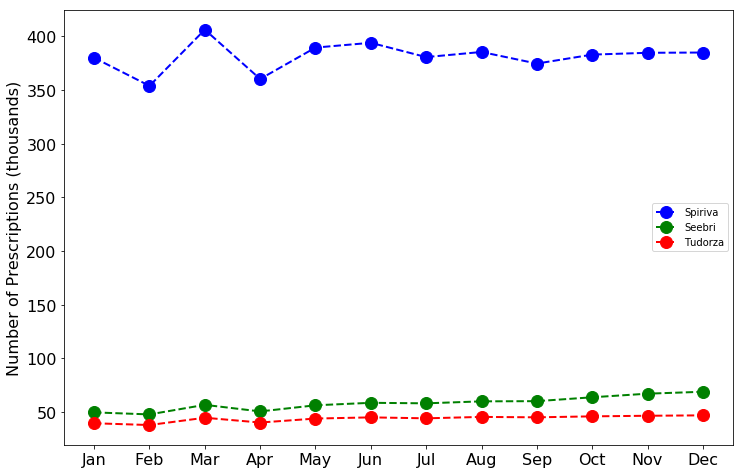

In [77]:
# Figure 5
import pandas as pd
import matplotlib.pyplot as plt

spiriva_df = pd.read_pickle('data/spirivaByPractice.pkl')
seebri_df = pd.read_pickle('data/seebriByPractice.pkl')
tudorza_df = pd.read_pickle('data/tudorzaByPractice.pkl')

spiriva_df = spiriva_df.sum(axis=0)
seebri_df = seebri_df.sum(axis=0)
tudorza_df = tudorza_df.sum(axis=0)

fig1 = plt.figure(figsize=(12,8))
plt.plot(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], spiriva_df/1000.0,color='blue',marker='o', linestyle='dashed',
        linewidth=2, markersize=12)
plt.plot(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], seebri_df/1000.0,color='green',marker='o', linestyle='dashed',
        linewidth=2, markersize=12)
plt.plot(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], tudorza_df/1000.0,color='red',marker='o', linestyle='dashed',
        linewidth=2, markersize=12)
plt.ylabel('Number of Prescriptions (thousands)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['Spiriva','Seebri','Tudorza'])

plt.savefig('Figure 5 - Rx By Month - Spiriva.png')
plt.show()

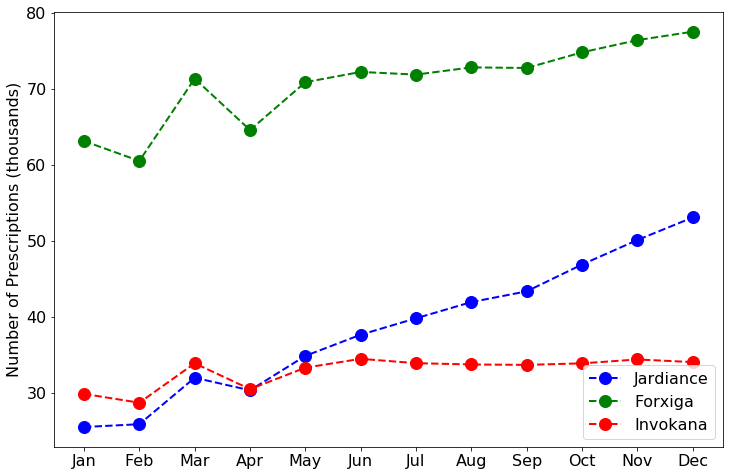

In [187]:
import pandas as pd
import matplotlib.pyplot as plt

jardiance_df = pd.read_pickle('data/jardianceByPractice.pkl')
forxiga_df = pd.read_pickle('data/forxigaByPractice.pkl')
invokana_df = pd.read_pickle('data/invokanaByPractice.pkl')

jardiance_df = jardiance_df.sum(axis=0)
forxiga_df = forxiga_df.sum(axis=0)
invokana_df = invokana_df.sum(axis=0)

fig1 = plt.figure(figsize=(12,8))
plt.plot(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], jardiance_df/1000.0,color='blue',marker='o', linestyle='dashed',
        linewidth=2, markersize=12)
plt.plot(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], forxiga_df/1000.0,color='green',marker='o', linestyle='dashed',
        linewidth=2, markersize=12)
plt.plot(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], invokana_df/1000.0,color='red',marker='o', linestyle='dashed',
        linewidth=2, markersize=12)
plt.ylabel('Number of Prescriptions (thousands)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['Jardiance','Forxiga','Invokana'],fontsize=16)

plt.savefig('Figure 7 - Rx By Month - Jardiance.png')
plt.show()



# Question 1-1

The following code produces the histogram of the full 2017 dataset.

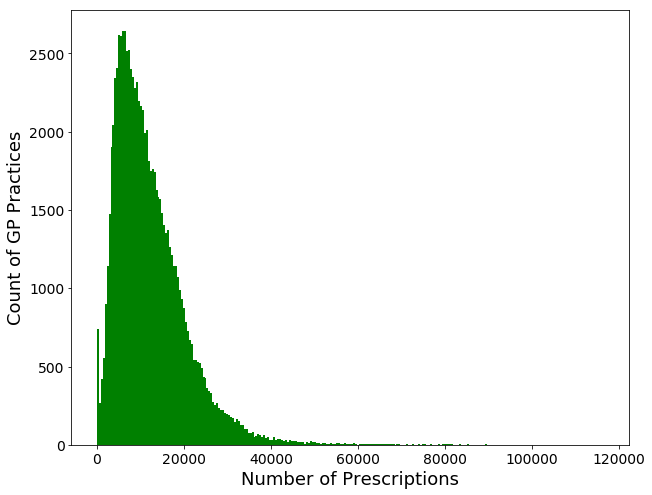

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RxByPractice_df = pd.read_pickle('data/OverallRxByPractice.pkl')
RxByPractice_df = RxByPractice_df.dropna(how='any')
fig1 = plt.figure(figsize=(10,8))
data = RxByPractice_df.values.flatten()
density, bin_edges = np.histogram(data,bins='auto')
bin_midpoints = [bin_edges[i] + (bin_edges[i+1]-bin_edges[i])/2.0 for i in range(len(bin_edges)-1)]
plt.bar(x=bin_midpoints, height=density,color='green',width=bin_edges[1]-bin_edges[0])

plt.xlabel('Number of Prescriptions', fontsize=18)
plt.ylabel('Count of GP Practices', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('Figure 1 - Rx By Practice - Overall.png')
plt.show()

## Guassian Mixed Model Approach

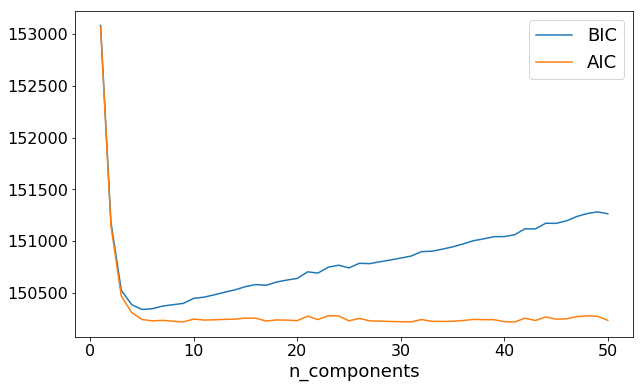

In [62]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

RxByPractice_df = pd.read_pickle('data/OverallRxByPractice.pkl')
RxByPractice_df = RxByPractice_df.dropna(how='any',axis=0)
RxByPractice_df['meanRx'] = RxByPractice_df.mean(axis=1)

data = np.array(RxByPractice_df['meanRx']).reshape(-1,1)

#look at AIC and BIC as a function of the number of components in the model
n_components = np.arange(1, 51)
models = [GaussianMixture(n, covariance_type='full').fit(data) for n in n_components]
plt.figure(figsize=(10,6))
plt.plot(n_components, [m.bic(data) for m in models], label='BIC')
plt.plot(n_components, [m.aic(data) for m in models], label='AIC')
plt.legend(loc='best',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('n_components',fontsize=18)
plt.savefig('Q1-1 components figure.png')

I decided to investigate the distribution of GP practice sizes in England. The following data were obtained from here: https://www.nhsbsa.nhs.uk/prescription-data/organisation-data/practice-list-size-and-gp-count-each-practice

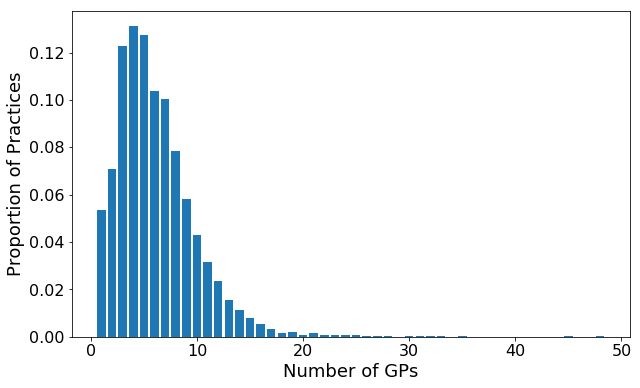

In [98]:
GP_df = pd.read_csv('data/General Practice September 2017 Practice Level.csv')
PracticeSize = GP_df.groupby('TOTAL_GP_HC')['TOTAL_GP_FTE'].count()
PracticeSize = PracticeSize / (PracticeSize.sum())
PracticeSize
plt.figure(figsize=(10,6))
plt.bar(x=list(PracticeSize.index+1),height=PracticeSize)
plt.xlabel('Number of GPs',fontsize=18)
plt.ylabel('Proportion of Practices',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Q1-1 practice size figure.png')

More than 98% of practices have 15 GPs or less, so I settled on 15 components in the mixture model.

In [179]:
finalGMM = GaussianMixture(15, covariance_type='diag').fit(data[:,0].reshape(-1,1))

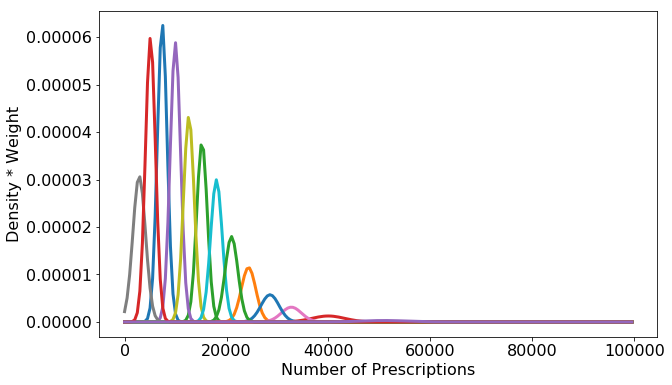

In [180]:
#plot the mixture components
from scipy.stats import norm
import math
x = np.arange(200) * 500
fig = plt.figure(figsize=(10,6))
for i in range(15):
    y = norm.pdf(x,finalGMM.means_[i],math.sqrt(finalGMM.covariances_[i]))
    plt.plot(x,finalGMM.weights_[i]*y,linewidth=3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Number of Prescriptions',fontsize=16)
plt.ylabel('Density * Weight',fontsize=16)
plt.savefig('gmm12.png')
plt.show()

In order to predict the component distribution for each practice I included data from each of the 12 months of 2017. 

In [182]:
# this assigns ranks to the component means. This allows me to map the GMM's component 
# representations to number of GPs in a practice. The ranks are my estimate of GP practice size.
array = np.array(finalGMM.means_)
order = array.argsort(axis=None)
ranks = order.argsort() + 1

rx_df = RxByPractice_df.copy()
rx_df.index.name = 'prac_code'
rx_df = rx_df.reset_index()
rx_df['estNumGPs'] = None

for i in range(len(rx_df)):
    likelihoods = finalGMM.predict_proba(np.array(rx_df.loc[i,'201701':'201712']).reshape(-1,1))
    rx_df.loc[i,'estNumGPs'] = ranks[np.argmax(likelihoods.prod(axis=0))]
pd.to_pickle(rx_df,'RxByPracticeWithPredictions.pkl')

The following produces a choropleth that illustrates mean practice size by postcode.

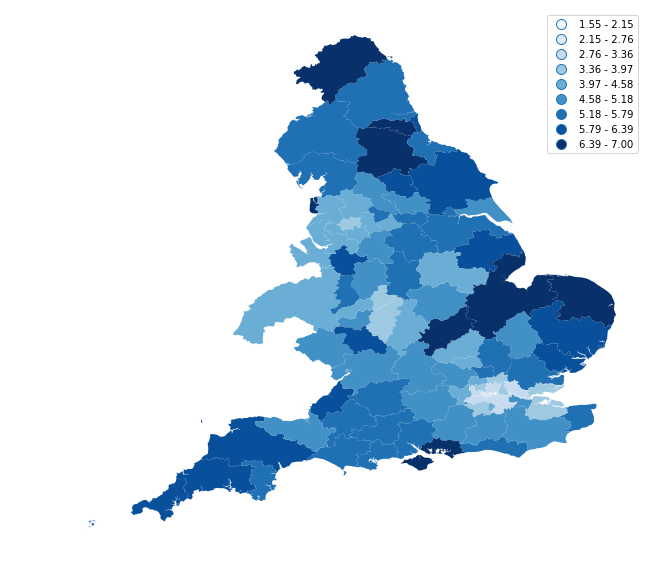

In [19]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# load the shapefile for the postcode map
gdf = gpd.read_file('PostalArea.shp')[['PostArea', 'geometry']].to_crs('+proj=robin')
    
# read the practice address data into a dataframe, join it with the prescribing data
postcode_df = pd.read_csv('data/2017/ADDR/T201712ADDR+BNFT.CSV',header=None)
postcode_df = postcode_df.drop([0,2,3,4,5,6],axis='columns')
postcode_df.columns = ['prac_code','postcode']
postcode_df['postcode'] = postcode_df['postcode'].str[:2]
for i in range(len(postcode_df)):
    if postcode_df.loc[i,'postcode'][-1] in [str(j) for j in range(10)]:
        postcode_df.loc[i,'postcode'] = postcode_df.loc[i,'postcode'][0]
postcode_df = postcode_df.set_index('prac_code')


# read the prescribing data into a dataframe
rx_df= pd.read_pickle('RxByPracticeWithPredictions.pkl')
rx_df = pd.merge(rx_df,postcode_df,on='prac_code')
rx_df['estNumGPs'] = rx_df['estNumGPs'].astype(int)
# group by postcode, then join with the geopandas dataframe
postcode_groupby = pd.DataFrame(rx_df.groupby('postcode')['estNumGPs'].mean())
postcode_groupby = postcode_groupby.reset_index()
merged = gdf.merge(postcode_groupby, left_on='PostArea', right_on='postcode')

# draw and save the plot
colors = 9
cmap = 'Blues'
figsize = (16, 10)
ax = merged.plot(column='estNumGPs', cmap=cmap, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
ax.set_axis_off()
plt.show()
#plt.savefig('EstPracticeSizeByPostcode.png')


# Question 1-2

Start by looking at the top and bottom performers in terms of overall prescriptions, as well as for Spiriva and Jardiance in particular. 

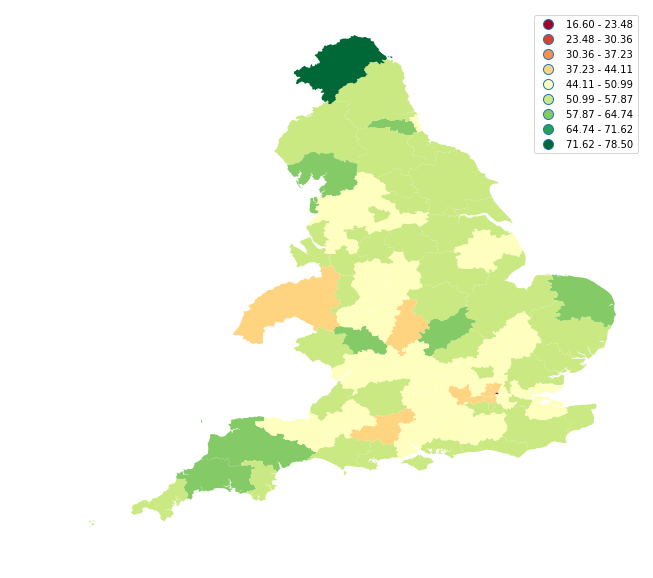

In [151]:
import pandas as pd
import numpy as np
import geopandas as gpd

# load the shapefile for the postcode map
gdf = gpd.read_file('PostalArea.shp')[['PostArea', 'geometry']].to_crs('+proj=robin')
    
# read the practice address data into a dataframe, join it with the prescribing data
postcode_df = pd.read_csv('data/2017/ADDR/T201712ADDR+BNFT.CSV',header=None)
postcode_df = postcode_df.drop([0,2,3,4,5,6],axis='columns')
postcode_df.columns = ['prac_code','postcode']
postcode_df['postcode'] = postcode_df['postcode'].str[:2]
for i in range(len(postcode_df)):
    if postcode_df.loc[i,'postcode'][-1] in [str(j) for j in range(10)]:
        postcode_df.loc[i,'postcode'] = postcode_df.loc[i,'postcode'][0]
postcode_df = postcode_df.set_index('prac_code')

# read the estimated GP counts
rx_df = pd.read_pickle('RxByPracticeWithPredictions.pkl')
rx_df = rx_df[['prac_code','estNumGPs']]
rx_df = pd.merge(rx_df,postcode_df,on='prac_code')
rx_df['estNumGPs'] = rx_df['estNumGPs'].astype(int)

#calculate quintiles and percentiles
RxByPractice_df = pd.read_pickle('data/OverallRxByPractice.pkl')
RxByPractice_df.index.name = 'prac_code'
RxByPractice_df['total_rx'] = RxByPractice_df.sum(axis=1)
RxByPractice_df = pd.merge(RxByPractice_df,rx_df,on='prac_code')
RxByPractice_df['RxPerGP'] = RxByPractice_df['total_rx'] / RxByPractice_df['estNumGPs']
percentiles = np.array(pd.qcut(RxByPractice_df['RxPerGP'].values,100,labels=np.arange(1,101)))
RxByPractice_df['percentile'] = percentiles
quintiles = np.array(pd.qcut(RxByPractice_df['RxPerGP'].values,5,labels=np.arange(1,6)))
RxByPractice_df['quintile'] = quintiles


# group by postcode, then join with the geopandas dataframe
postcode_groupby = pd.DataFrame(RxByPractice_df.groupby('postcode')['percentile'].mean())
postcode_groupby = postcode_groupby.reset_index()
merged = gdf.merge(postcode_groupby, left_on='PostArea', right_on='postcode')

# draw and save the plot
colors = 9
cmap = 'RdYlGn'
figsize = (16, 10)
ax = merged.plot(column='percentile', cmap=cmap, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
ax.set_axis_off()
plt.savefig('PercentileByPostcodeOverall.png')

Repeat for Spiriva and Jardiance.

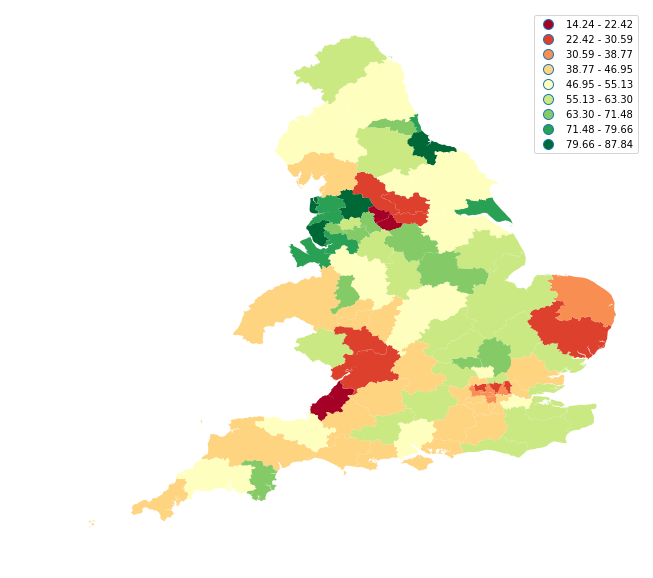

In [152]:
import pandas as pd
import numpy as np
import geopandas as gpd

# load the shapefile for the postcode map
gdf = gpd.read_file('PostalArea.shp')[['PostArea', 'geometry']].to_crs('+proj=robin')
    
# read the practice address data into a dataframe, join it with the prescribing data
postcode_df = pd.read_csv('data/2017/ADDR/T201712ADDR+BNFT.CSV',header=None)
postcode_df = postcode_df.drop([0,2,3,4,5,6],axis='columns')
postcode_df.columns = ['prac_code','postcode']
postcode_df['postcode'] = postcode_df['postcode'].str[:2]
for i in range(len(postcode_df)):
    if postcode_df.loc[i,'postcode'][-1] in [str(j) for j in range(10)]:
        postcode_df.loc[i,'postcode'] = postcode_df.loc[i,'postcode'][0]
postcode_df = postcode_df.set_index('prac_code')

# read the estimated GP counts
rx_df = pd.read_pickle('RxByPracticeWithPredictions.pkl')
rx_df = rx_df[['prac_code','estNumGPs']]
rx_df = pd.merge(rx_df,postcode_df,on='prac_code')
rx_df['estNumGPs'] = rx_df['estNumGPs'].astype(int)

#calculate quintiles and percentiles
RxByPractice_df = pd.read_pickle('data/spirivaByPractice.pkl')

RxByPractice_df.index.name = 'prac_code'
RxByPractice_df['total_rx'] = RxByPractice_df.sum(axis=1)
RxByPractice_df = pd.merge(RxByPractice_df,rx_df,on='prac_code')
RxByPractice_df['RxPerGP'] = RxByPractice_df['total_rx'] / RxByPractice_df['estNumGPs']
percentiles = np.array(pd.qcut(RxByPractice_df['RxPerGP'].values,100,labels=np.arange(1,101)))
RxByPractice_df['percentile'] = percentiles
quintiles = np.array(pd.qcut(RxByPractice_df['RxPerGP'].values,5,labels=np.arange(1,6)))
RxByPractice_df['quintile'] = quintiles


# group by postcode, then join with the geopandas dataframe
postcode_groupby = pd.DataFrame(RxByPractice_df.groupby('postcode')['percentile'].mean())
postcode_groupby = postcode_groupby.reset_index()
merged = gdf.merge(postcode_groupby, left_on='PostArea', right_on='postcode')

# draw and save the plot
colors = 9
cmap = 'RdYlGn'
figsize = (16, 10)
ax = merged.plot(column='percentile', cmap=cmap, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
ax.set_axis_off()
plt.savefig('PercentileByPostcodeSpiriva.png')

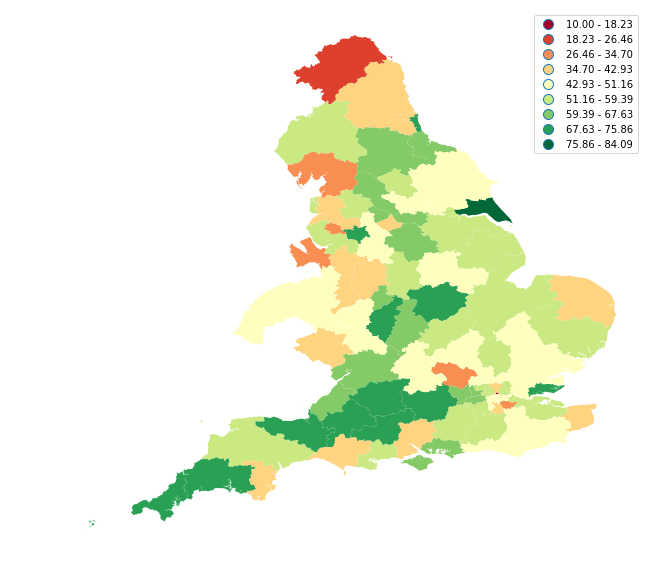

In [162]:
# import pandas as pd
import numpy as np
import geopandas as gpd

# load the shapefile for the postcode map
gdf = gpd.read_file('PostalArea.shp')[['PostArea', 'geometry']].to_crs('+proj=robin')
    
# read the practice address data into a dataframe, join it with the prescribing data
postcode_df = pd.read_csv('data/2017/ADDR/T201712ADDR+BNFT.CSV',header=None)
postcode_df = postcode_df.drop([0,2,3,4,5,6],axis='columns')
postcode_df.columns = ['prac_code','postcode']
postcode_df['postcode'] = postcode_df['postcode'].str[:2]
for i in range(len(postcode_df)):
    if postcode_df.loc[i,'postcode'][-1] in [str(j) for j in range(10)]:
        postcode_df.loc[i,'postcode'] = postcode_df.loc[i,'postcode'][0]
postcode_df = postcode_df.set_index('prac_code')

# read the estimated GP counts
rx_df = pd.read_pickle('RxByPracticeWithPredictions.pkl')
rx_df = rx_df[['prac_code','estNumGPs']]
rx_df = pd.merge(rx_df,postcode_df,on='prac_code')
rx_df['estNumGPs'] = rx_df['estNumGPs'].astype(int)

#calculate quintiles and percentiles
RxByPractice_df = pd.read_pickle('data/jardianceByPractice.pkl')

RxByPractice_df.index.name = 'prac_code'
RxByPractice_df['total_rx'] = RxByPractice_df.sum(axis=1)
RxByPractice_df = pd.merge(RxByPractice_df,rx_df,on='prac_code')
RxByPractice_df['RxPerGP'] = RxByPractice_df['total_rx'] / RxByPractice_df['estNumGPs']
percentiles = np.array(pd.qcut(RxByPractice_df['RxPerGP'].values,10,labels=np.arange(10,101,10)))
RxByPractice_df['percentile'] = percentiles.astype(int)
quintiles = np.array(pd.qcut(RxByPractice_df['RxPerGP'].values,5,labels=np.arange(1,6)))
RxByPractice_df['quintile'] = quintiles


# group by postcode, then join with the geopandas dataframe
postcode_groupby = pd.DataFrame(RxByPractice_df.groupby('postcode')['percentile'].mean())
postcode_groupby = postcode_groupby.reset_index()
merged = gdf.merge(postcode_groupby, left_on='PostArea', right_on='postcode')

# draw and save the plot
colors = 9
cmap = 'RdYlGn'
figsize = (16, 10)
ax = merged.plot(column='percentile', cmap=cmap, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
ax.set_axis_off()
plt.savefig('PercentileByPostcodeJardiance.png')

## Even More Plots

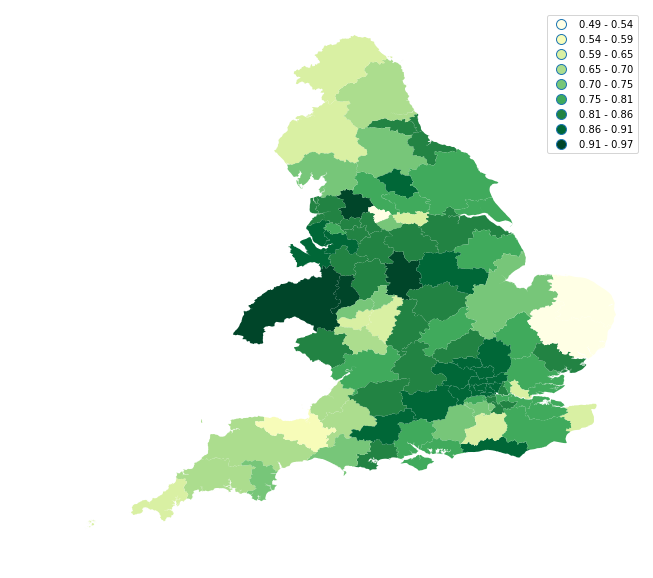

In [96]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# load the shapefile for the postcode map
gdf = gpd.read_file('PostalArea.shp')[['PostArea', 'geometry']].to_crs('+proj=robin')
    
# read the practice address data into a dataframe, join it with the prescribing data
postcode_df = pd.read_csv('data/2017/ADDR/T201712ADDR+BNFT.CSV',header=None)
postcode_df = postcode_df.drop([0,2,3,4,5,6],axis='columns')
postcode_df.columns = ['prac_code','postcode']
postcode_df['postcode'] = postcode_df['postcode'].str[:2]
for i in range(len(postcode_df)):
    if postcode_df.loc[i,'postcode'][-1] in [str(j) for j in range(10)]:
        postcode_df.loc[i,'postcode'] = postcode_df.loc[i,'postcode'][0]
postcode_df = postcode_df.set_index('prac_code')

# read the prescribing data into a dataframe
spiriva_df = pd.read_pickle('data/spirivaByPractice.pkl')
seebri_df = pd.read_pickle('data/seebriByPractice.pkl')
tudorza_df = pd.read_pickle('data/tudorzaByPractice.pkl')

# sum across months
spiriva_df = pd.DataFrame(spiriva_df.sum(axis=1),columns=['spiriva'])
spiriva_df.index.name = 'prac_code'
spiriva_df = spiriva_df.fillna(0.0)

seebri_df = pd.DataFrame(seebri_df.sum(axis=1),columns=['seebri'])
seebri_df.index.name = 'prac_code'
seebri_df = seebri_df.fillna(0.0)

tudorza_df = pd.DataFrame(tudorza_df.sum(axis=1),columns=['tudorza'])
tudorza_df.index.name = 'prac_code'
tudorza_df = tudorza_df.fillna(0.0)

sum_drugs = spiriva_df.merge(seebri_df, left_on='prac_code', right_on='prac_code')
sum_drugs = sum_drugs.merge(tudorza_df, left_on='prac_code', right_on='prac_code')
sum_drugs['total'] = sum_drugs['spiriva'] + sum_drugs['seebri'] + sum_drugs['tudorza']
sum_drugs = sum_drugs.drop(['seebri','tudorza'],axis=1)
sum_drugs = sum_drugs.dropna(how='any')

ratio_df = pd.merge(sum_drugs,postcode_df,left_on='prac_code',right_on='prac_code')

# group by postcode, then join with the geopandas dataframe
postcode_groupby = pd.DataFrame(ratio_df.groupby('postcode')['spiriva','total'].sum())
postcode_groupby = postcode_groupby.reset_index()
postcode_groupby['ratio'] = postcode_groupby['spiriva'] / postcode_groupby['total']
merged = gdf.merge(postcode_groupby, left_on='PostArea', right_on='postcode')

# draw and save the plot
colors = 9
cmap = 'YlGn'
figsize = (16, 10)
ax = merged.plot(column='ratio', cmap=cmap, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
ax.set_axis_off()
plt.savefig('Figure 6 - SpirivaMarketShareByPostcode.png')

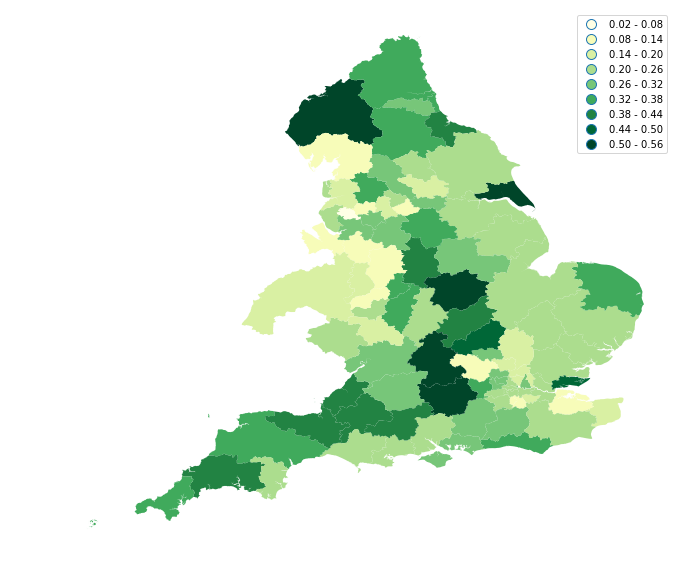

In [98]:
# Figure 8

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# load the shapefile for the postcode map
gdf = gpd.read_file('PostalArea.shp')[['PostArea', 'geometry']].to_crs('+proj=robin')
    
# read the practice address data into a dataframe, join it with the prescribing data
postcode_df = pd.read_csv('data/2017/ADDR/T201712ADDR+BNFT.CSV',header=None)
postcode_df = postcode_df.drop([0,2,3,4,5,6],axis='columns')
postcode_df.columns = ['prac_code','postcode']
postcode_df['postcode'] = postcode_df['postcode'].str[:2]
for i in range(len(postcode_df)):
    if postcode_df.loc[i,'postcode'][-1] in [str(j) for j in range(10)]:
        postcode_df.loc[i,'postcode'] = postcode_df.loc[i,'postcode'][0]
postcode_df = postcode_df.set_index('prac_code')

# read the prescribing data into a dataframe
jardiance_df = pd.read_pickle('data/jardianceByPractice.pkl')
forxiga_df = pd.read_pickle('data/forxigaByPractice.pkl')
invokana_df = pd.read_pickle('data/invokanaByPractice.pkl')

# sum across months
jardiance_df = pd.DataFrame(jardiance_df.sum(axis=1),columns=['jardiance'])
jardiance_df.index.name = 'prac_code'
jardiance_df = jardiance_df.fillna(0.0)

forxiga_df = pd.DataFrame(forxiga_df.sum(axis=1),columns=['forxiga'])
forxiga_df.index.name = 'prac_code'
forxiga_df = forxiga_df.fillna(0.0)

invokana_df = pd.DataFrame(invokana_df.sum(axis=1),columns=['invokana'])
invokana_df.index.name = 'prac_code'
invokana_df = invokana_df.fillna(0.0)

sum_drugs = jardiance_df.merge(forxiga_df, left_on='prac_code', right_on='prac_code')
sum_drugs = sum_drugs.merge(invokana_df, left_on='prac_code', right_on='prac_code')
sum_drugs['total'] = sum_drugs['jardiance'] + sum_drugs['forxiga'] + sum_drugs['invokana']
sum_drugs = sum_drugs.drop(['forxiga','invokana'],axis=1)
sum_drugs = sum_drugs.dropna(how='any')

ratio_df = pd.merge(sum_drugs,postcode_df,left_on='prac_code',right_on='prac_code')

# group by postcode, then join with the geopandas dataframe
postcode_groupby = pd.DataFrame(ratio_df.groupby('postcode')['jardiance','total'].sum())
postcode_groupby = postcode_groupby.reset_index()
postcode_groupby['ratio'] = postcode_groupby['jardiance'] / postcode_groupby['total']
merged = gdf.merge(postcode_groupby, left_on='PostArea', right_on='postcode')

# draw and save the plot
colors = 9
cmap = 'YlGn'
figsize = (16, 10)
ax = merged.plot(column='ratio', cmap=cmap, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
ax.set_axis_off()
plt.savefig('Figure 8 - JardianceMarketShareByPostcode.png')

# Question 2

The following two cells produce the plots for the Q2 intro slides.

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 <a list of 8 Text yticklabel objects>)

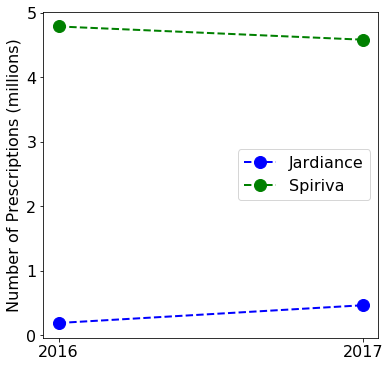

In [63]:
# the following draws the plots for the Q2 intro slides
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

mean_jar_2016 = pd.read_pickle('data/2016criterion_jardiance.pkl')['2016'].sum()
mean_jar_2017 = pd.read_pickle('data/2017criterion_jardiance.pkl')['2017'].sum()
mean_spi_2016 = pd.read_pickle('data/2016criterion_spiriva.pkl')['2016'].sum()
mean_spi_2017 = pd.read_pickle('data/2017criterion_spiriva.pkl')['2017'].sum()
plt.figure(figsize=(6,6))
plt.plot(['2016','2017'],[mean_jar_2016/1000000.0,mean_jar_2017/1000000.0],color='blue',marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.plot(['2016','2017'],[mean_spi_2016/1000000.0,mean_spi_2017/1000000.0],color='green',marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.legend(['Jardiance','Spiriva'],fontsize=16)
plt.ylabel('Number of Prescriptions (millions)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

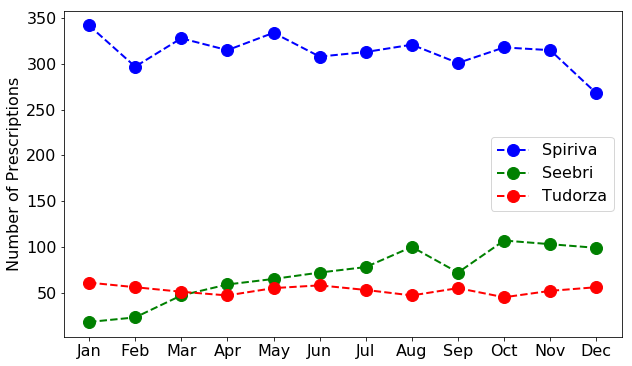

In [72]:
spiriva_df = pd.read_pickle('data/spirivaByPractice.pkl')
seebri_df = pd.read_pickle('data/seebriByPractice.pkl')
tudorza_df = pd.read_pickle('data/tudorzaByPractice.pkl')

y1=spiriva_df.loc['A81002',:].values
y2=seebri_df.loc['A81002',:].values
y3=tudorza_df.loc['A81002',:].values

fig1 = plt.figure(figsize=(10,6))
plt.plot(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], y1,color='blue',marker='o', linestyle='dashed',
        linewidth=2, markersize=12)
plt.plot(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], y2,color='green',marker='o', linestyle='dashed',
        linewidth=2, markersize=12)
plt.plot(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], y3,color='red',marker='o', linestyle='dashed',
        linewidth=2, markersize=12)
plt.ylabel('Number of Prescriptions', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['Spiriva','Seebri','Tudorza'],fontsize=16)

#plt.savefig('Figure 5 - Rx By Month - Spiriva.png')
plt.show()

## Q2 - Data Consolidation

The following two cells include the PySpark code to run the data consolidation for Question 2. This code was run on a Spark/Hadoop cluster on Google Cloud Platform.

In [ ]:
#classes.py

class RxRecord(object):

    def __init__(self, sha, pct, practice, bnf_code, bnf_name, items, nic, act_cost, quantity, period):

        self.sha = sha
        self.pct = pct
        self.practice = practice
        self.bnf_code = bnf_code
        self.bnf_name = bnf_name
        self.items = items
        self.nic = nic
        self.act_cost = act_cost
        self.quantity = quantity
        self.period = period

    @classmethod
    def parse(cls, s):
        varnames = ['sha', 'pct', 'practice', 'bnf_code', 'bnf_name', 'items', 'nic', 'act_cost', 'quantity', 'period']
        for var in varnames:
            exec(var + ' = None')
        try:
            split_line = s.split(',')
            for i in range(len(varnames)):
                exec(varnames[i] + ' = "' + split_line[i].strip() + '"')
        except:
            pass
        return cls(sha, pct, practice, bnf_code, bnf_name, int(items), nic, act_cost, quantity, period)

In [ ]:
#main.py
import pandas as pd
from pyspark import SparkContext
from classes import RxRecord

sc = SparkContext()

chapter_dict = {}
chapter_dict['spiriva'] = '03'
chapter_dict['jardinance'] = '06'

def headerRow(s):
    return s.strip()[:7] != u'SHA,PCT'

def checkChapter(s,chapter):
    return s[:2] == chapter


#start by loading a list of practices, and filtering out the ones that are not GP practices.
practice_df = pd.read_csv('/home/hoodain/epraccur.csv',header=None)
# A 4 in column 25 indicates a GP Practice
practice_df = practice_df[practice_df[25] == 4]
practiceTuples = sc.parallelize(zip(list(practice_df[0]),[0] * len(practice_df)))


for year in ['2016','2017','2018']:
    #read in all PDPI files for the year and parse them
    RxFull = sc.textFile('gs://bi-justin-macdonald/data/{}/PDPI/'.format(year)) \
        .filter(lambda x: headerRow(x)) \
        .map(RxRecord.parse) \
        .cache()
    
    # this produces a big list of tuples in the format 
    # ((practice_code,bnf_code,period), items)
    for drugname in ['spiriva','jardiance']:
        RxFiltered = RxFull \
            .filter(lambda x: checkChapter(x.bnf_code,chapter_dict[drugname])) \
            .map(lambda x: (x.practice, (x.period, x.bnf_code,x.items))) \
            .join(practiceTuples) \
            .map(lambda (practice_code, ((period, bnf_code,items),v)): ((practice_code,bnf_code,period), items)) \
            .reduceByKey(lambda x,y: x + y) \
            .collect()
        pd.to_pickle(RxFiltered,'/home/hoodain/Preconverted{}data_{}.pkl'.format(year,drugname))

## Q2 - Model building

The remainder of the coding was done locally. The output from the Spark code needed to be reformatted into a dataframe and summarized to be used as the list of features for the models.

In [6]:
# this code constructs the features dataframe
import pandas as pd
import numpy as np

def compressIntoDataframe(filename):
    rx_df = pd.DataFrame()
    RxDataset = sorted(pd.read_pickle(filename))
    current_prac = RxDataset[0][0][0]
    current_bnf_code = RxDataset[0][0][1][:9]
    bnf_data = np.zeros(12)
    bnf_data[int(RxDataset[0][0][2][-2:])-1] = int(RxDataset[0][1])
    for i in range(1,len(RxDataset)):
        new_prac = RxDataset[i][0][0]
        new_bnf_code = RxDataset[i][0][1][:9]
        if new_prac != current_prac or new_bnf_code != current_bnf_code:        
            if np.sum(bnf_data) > np.max(bnf_data): #there is more than one item in the array
                dataX = np.arange(12)
                dataX = dataX[bnf_data != 0]
                dataY = bnf_data[bnf_data != 0]
                result = np.polyfit(x=dataX,y=dataY,deg=1)
                slope = result[0]
            else:
                slope = 0.0
            rx_df.loc[current_prac,current_bnf_code] = slope
            current_prac = new_prac
            current_bnf_code = new_bnf_code
            bnf_data = np.zeros(12)
        bnf_data[int(RxDataset[i][0][2][-2:])-1] += int(RxDataset[i][1])
    return rx_df.fillna(0.0)

# I need a list of features for Spiriva and Jardiance for 2016 & 2017
for drugname in ['spiriva','jardiance']:
    for year in ['2016','2017']:
        filename = 'data/Preconverted{}data_{}.pkl'.format(year,drugname)
        features = compressIntoDataframe(filename)
        pd.to_pickle(features,'data/{}features_{}2.pkl'.format(year,drugname))

In [202]:
# this code constructs the criterion dataframe
import pandas as pd
import numpy as np

bnf_dict = {}
bnf_dict['spiriva'] = ['0301020Q0','0301040X0']
bnf_dict['jardiance'] = ['0601023AN','0601023AR']

def compressIntoDataframe2(filename):
    rx_df = pd.DataFrame()
    RxDataset = sorted(pd.read_pickle(filename))
    current_prac = RxDataset[0][0][0]
    current_bnf_code = RxDataset[0][0][1]
    data = [RxDataset[0][1]]
    for i in range(1,len(RxDataset)):
        new_prac = RxDataset[i][0][0]
        new_bnf_code = RxDataset[i][0][1]
        if new_prac != current_prac or new_bnf_code != current_bnf_code:        
            rx_df.loc[current_prac,current_bnf_code] = sum(data)
            current_prac = new_prac
            current_bnf_code = new_bnf_code
            data = []
        data.append(RxDataset[i][1])
    return rx_df.fillna(0.0)

for drugname in ['spiriva','jardiance']:
    for year in ['2016','2017']:
        filename = 'data/Preconverted{}data_{}.pkl'.format(year,drugname)
        criterion = compressIntoDataframe2(filename)
        sum_series = np.zeros(len(criterion))
        for col in criterion.columns:
            if col[:9] == bnf_dict[drugname][0] or col[:9] == bnf_dict[drugname][1]:
                sum_series += np.array(criterion[col])
        criterion = pd.DataFrame(criterion.index,columns=['prac_code'])
        criterion[year] = sum_series
        pd.to_pickle(criterion,'data/{}criterion_{}.pkl'.format(year,drugname))

I then started building the regression models. Train using 2016 data to predict the number of new Spiriva/Jardiance prescriptions in 2017.


## Q2 - Spiriva Model

In [ ]:
import pandas as pd
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor

spiriva2016 = pd.read_pickle('data/2016criterion_spiriva.pkl')
spiriva2017 = pd.read_pickle('data/2017criterion_spiriva.pkl')

merged_y = spiriva2017.merge(spiriva2016, left_on='prac_code',right_on='prac_code')
y_train = merged_y['2017'] - merged_y['2016']

x = pd.read_pickle('data/2016features_spiriva2.pkl')
x.index.name = 'prac_code'
x = x.reset_index()
merged_x = x.merge(merged_y, left_on='prac_code',right_on='prac_code')
x_train = merged_x.drop(['2016','2017'],axis=1).set_index('prac_code')
model_featurelist = x_train.columns

param_grid = {'bootstrap': [True, False],
             'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10]}
rfr = RandomForestRegressor()
rfr_random = model_selection.GridSearchCV(estimator = rfr, param_grid = param_grid, verbose=4, n_jobs = 3)
rfr_random.fit(x_train, y_train)
rfr_random.best_params_

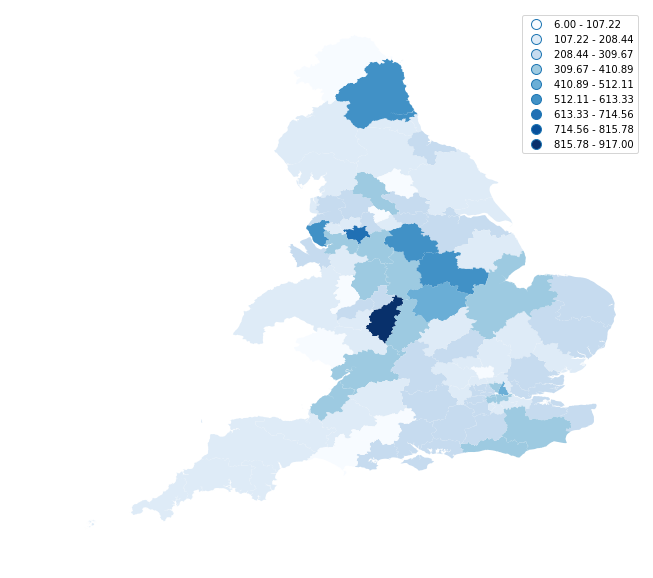

In [118]:
# train the model on the full training dataset and save the trained mdoel to disk
from sklearn.externals import joblib
rfr = RandomForestRegressor(n_estimators=500,bootstrap=True, min_samples_leaf=4, min_samples_split=10, max_depth=10)
rfr.fit(x_train,y_train)
joblib.dump(rfr, 'rfr_model_spiriva.pkl', compress=3) 

# use the trained model to predict new 2018 prescriptions from 2017 data
# features need to be adjusted slightly since medications have changed from 2016 to 2017.
x_validate = pd.read_pickle('data/2017features_spiriva2.pkl')
droplist = []
for col in x_validate.columns:
    if col not in model_featurelist:
        droplist.append(col)
x_validate = x_validate.drop(droplist,axis=1)
x_validate2 = pd.DataFrame(np.zeros([len(x_validate),len(model_featurelist)]),index=x_validate.index,columns=model_featurelist)
for col in x_validate.columns:
    x_validate2[col] = x_validate[col]
y_hat = rfr2.predict(x_validate2)

#put the 2018 predictions into a dataframe
results = pd.DataFrame(y_hat,index=x_validate2.index,columns=['estNewRx'])
results.index.name = 'prac_code'
results = results.reset_index()

# read the practice address data into a dataframe, join it with the prescribing data
postcode_df = pd.read_csv('data/2017/ADDR/T201712ADDR+BNFT.CSV',header=None)
postcode_df = postcode_df.drop([0,2,3,4,5,6],axis='columns')
postcode_df.columns = ['prac_code','postcode']
postcode_df['postcode'] = postcode_df['postcode'].str[:2]
for i in range(len(postcode_df)):
    if postcode_df.loc[i,'postcode'][-1] in [str(j) for j in range(10)]:
        postcode_df.loc[i,'postcode'] = postcode_df.loc[i,'postcode'][0]
postcode_df = postcode_df.set_index('prac_code')
results = results.merge(postcode_df,on='prac_code')

#read in the file that holds the estiamted number of GPs for each practice
rx_df = pd.read_pickle('RxByPracticeWithPredictions.pkl')
rx_df = rx_df[['prac_code','estNumGPs']]
results = results.merge(rx_df,on='prac_code')

#this is the statistic that we care about, it is new Rx per GP at each practice
results['newRxPerGP'] = results['estNewRx'] / results['estNumGPs']
results = results.sort_values(by='newRxPerGP',ascending=False)
results = results.reset_index()

# Put the top 70% on the visit list
totalEstGPs = results['estNumGPs'].sum()
numToVisit = int(0.7 * totalEstGPs)
visitList = pd.DataFrame(columns=results.columns)
i = 0
GPs_visited = 0
while GPs_visited < numToVisit:
    visitList.loc[i,:] = results.loc[i,:]
    GPs_visited += results.loc[i,'estNumGPs']
    i += 1
pd.to_pickle(visitList,'Q2_visitlist_spiriva.pkl')

#make a pretty map to show where visits are located
visit_gb = pd.DataFrame(visitList.groupby('postcode')['estNumGPs'].sum())

# load the shapefile for the postcode map
gdf = gpd.read_file('PostalArea.shp')[['PostArea', 'geometry']].to_crs('+proj=robin')
merged = gdf.merge(visit_gb, left_on='PostArea', right_on='postcode')

# draw and save the plot
colors = 9
cmap = 'Blues'
figsize = (16, 10)
ax = merged.plot(column='estNumGPs', cmap=cmap, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
ax.set_axis_off()
plt.savefig('NumGPvisitsByPostcodeSpiriva.png')
plt.show()

## Q2 - Jardiance model

The code for the Jardiance model is nearly the same.

In [ ]:
import pandas as pd
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor

jardiance2016 = pd.read_pickle('data/2016criterion_jardiance.pkl')
jardiance2017 = pd.read_pickle('data/2017criterion_jardiance.pkl')

merged_y = jardiance2017.merge(jardiance2016, left_on='prac_code',right_on='prac_code')
y_train = merged_y['2017'] - merged_y['2016']

x = pd.read_pickle('data/2016features_jardiance2.pkl')
x.index.name = 'prac_code'
x = x.reset_index()
merged_x = x.merge(merged_y, left_on='prac_code',right_on='prac_code')
x_train = merged_x.drop(['2016','2017'],axis=1).set_index('prac_code')
model_featurelist = x_train.columns

param_grid = {'bootstrap': [True, False],
             'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10]}
rfr2 = RandomForestRegressor()
rfr2_random = model_selection.GridSearchCV(estimator = rfr2, param_grid = param_grid, verbose=4, n_jobs = 3)
rfr2_random.fit(x_train, y_train)
rfr2_random.best_params_

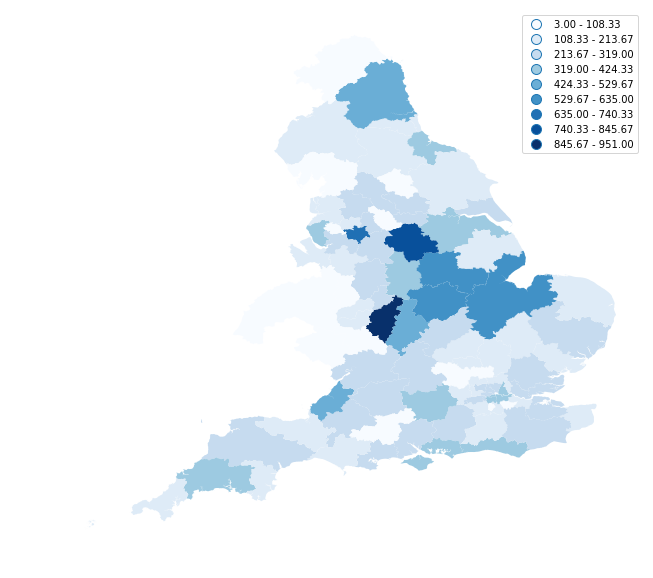

<Figure size 432x288 with 0 Axes>

In [115]:
# train the model on the full training dataset and save the trained mdoel to disk
from sklearn.externals import joblib
rfr2 = RandomForestRegressor(n_estimators=1000,bootstrap=True, min_samples_leaf=1, min_samples_split=10, max_depth=10)
rfr2.fit(x_train,y_train)
joblib.dump(rfr2, 'rfr_model_jardiance.pkl', compress=3) 

# use the trained model to predict new 2018 prescriptions from 2017 data
# features need to be adjusted slightly since medications have changed from 2016 to 2017.
x_validate = pd.read_pickle('data/2017features_jardiance2.pkl')
droplist = []
for col in x_validate.columns:
    if col not in model_featurelist:
        droplist.append(col)
x_validate = x_validate.drop(droplist,axis=1)
x_validate2 = pd.DataFrame(np.zeros([len(x_validate),len(model_featurelist)]),index=x_validate.index,columns=model_featurelist)
for col in x_validate.columns:
    x_validate2[col] = x_validate[col]
y_hat = rfr2.predict(x_validate2)

#put the 2018 predictions into a dataframe
results = pd.DataFrame(y_hat,index=x_validate2.index,columns=['estNewRx'])
results.index.name = 'prac_code'
results = results.reset_index()

# read the practice address data into a dataframe, join it with the prescribing data
postcode_df = pd.read_csv('data/2017/ADDR/T201712ADDR+BNFT.CSV',header=None)
postcode_df = postcode_df.drop([0,2,3,4,5,6],axis='columns')
postcode_df.columns = ['prac_code','postcode']
postcode_df['postcode'] = postcode_df['postcode'].str[:2]
for i in range(len(postcode_df)):
    if postcode_df.loc[i,'postcode'][-1] in [str(j) for j in range(10)]:
        postcode_df.loc[i,'postcode'] = postcode_df.loc[i,'postcode'][0]
postcode_df = postcode_df.set_index('prac_code')
results = results.merge(postcode_df,on='prac_code')

#read in the file that holds the estiamted number of GPs for each practice
rx_df = pd.read_pickle('RxByPracticeWithPredictions.pkl')
rx_df = rx_df[['prac_code','estNumGPs']]
results = results.merge(rx_df,on='prac_code')

#this is the statistic that we care about, it is new Rx per GP at each practice
results['newRxPerGP'] = results['estNewRx'] / results['estNumGPs']
results = results.sort_values(by='newRxPerGP',ascending=False)
results = results.reset_index()

# Put the top 70% on the visit list
totalEstGPs = results['estNumGPs'].sum()
numToVisit = int(0.7 * totalEstGPs)
visitList = pd.DataFrame(columns=results.columns)
i = 0
GPs_visited = 0
while GPs_visited < numToVisit:
    visitList.loc[i,:] = results.loc[i,:]
    GPs_visited += results.loc[i,'estNumGPs']
    i += 1
pd.to_pickle(visitList,'Q2_visitlist_jardiance.pkl')

#make a pretty map to show where visits are located
visit_gb = pd.DataFrame(visitList.groupby('postcode')['estNumGPs'].sum())

# load the shapefile for the postcode map
gdf = gpd.read_file('PostalArea.shp')[['PostArea', 'geometry']].to_crs('+proj=robin')
merged = gdf.merge(visit_gb, left_on='PostArea', right_on='postcode')

# draw and save the plot
colors = 9
cmap = 'Blues'
figsize = (16, 10)
ax = merged.plot(column='estNumGPs', cmap=cmap, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
ax.set_axis_off()
plt.savefig('NumGPvisitsByPostcodeJardiance.png')
plt.show()